# CNN Trial Architectures

## Importing Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
import torch.nn.functional as F

## Loading the data

In [2]:
cm21_maps = np.load('/kaggle/input/ionizedfields32/Preprocessed21cm.npz')['array']
halo_maps = np.load('/kaggle/input/ionizedfields32/PreprocessedHalo.npz')['array']
dm_maps = np.load('/kaggle/input/ionizedfields32/PreprocessedDM.npz')['array']

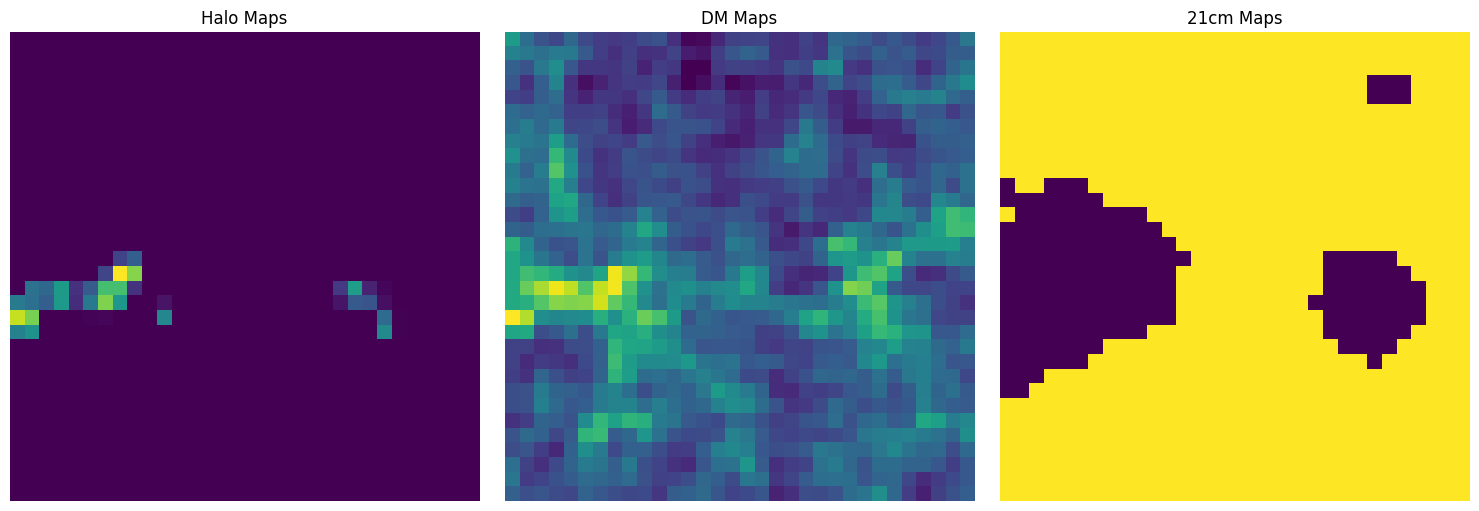

In [3]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Display the images in subplots
axs[0].imshow(halo_maps[43][0][13])
axs[0].set_title('Halo Maps')

axs[1].imshow(dm_maps[43][0][13])
axs[1].set_title('DM Maps')

axs[2].imshow(cm21_maps[43][0][13])
axs[2].set_title('21cm Maps')

# Remove axes for a cleaner look
for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [4]:
# Converting to PyTorch tensors
input_tensor = torch.tensor(halo_maps, dtype=torch.float32)
output_tensor = torch.tensor(cm21_maps, dtype=torch.float32)

# Creating a TensorDataset and DataLoader
dataset = TensorDataset(input_tensor, output_tensor)
batch_size = 100
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

## UNet Architecture

In [5]:
import torch
import torch.nn as nn

class UNet3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet3D, self).__init__()
        
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv3d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.enc2 = nn.Sequential(
            nn.MaxPool3d(kernel_size=2),
            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.MaxPool3d(kernel_size=2),
            nn.Conv3d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2)
        )
        
        # Decoder
        self.dec2 = nn.Sequential(
            nn.Conv3d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2)
        )
        self.dec1 = nn.Sequential(
            nn.Conv3d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(64, out_channels, kernel_size=1)
        )
    
    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        
        # Bottleneck
        bottleneck = self.bottleneck(enc2)
        
        # Decoder with skip connections
        dec2 = self.dec2(torch.cat((bottleneck, enc2), dim=1))
        dec1 = self.dec1(torch.cat((dec2, enc1), dim=1))
        
        return dec1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = UNet3D(in_channels=1, out_channels=1).to(device)

cuda


## Training Process

In [6]:
# Defining the loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Splitting data into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Loading them into batches for more efficient RAM usage
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Early stopping parameters: so that our training process stops the moment there is no improvement in the validation loss
early_stopping_patience = 10 # these are number of times we will wait if our model improves (if its not improving)
min_val_loss = float('inf') # initializing the min_val_loss
patience_counter = 0 # number of times the validation loss didn't improve if it exceeds half the training process

# Lists for saving losses and R^2 scores (we will use it later)
train_losses = []
val_losses = []
train_r2_scores = []
val_r2_scores = []

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
    
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    # Calculating R^2 scores for training and validation sets
    train_r2 = 1 - (train_loss / np.var(output_tensor.numpy()))
    val_r2 = 1 - (val_loss / np.var(output_tensor.numpy()))
    train_r2_scores.append(train_r2)
    val_r2_scores.append(val_r2)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train R^2: {train_r2:.4f}, Val R^2: {val_r2:.4f}')

    # Early stopping
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        patience_counter = 0
        # Saving the model with the best validation loss
        torch.save(model.state_dict(), 'best_model.pth') # it does slows the process of a bit, but still better than unnecessary epochs that will consume GPU
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping")
            break

Epoch 1/10, Train Loss: 0.4838, Val Loss: 0.2573, Train R^2: -0.9987, Val R^2: -0.0627
Epoch 2/10, Train Loss: 0.2555, Val Loss: 0.2500, Train R^2: -0.0554, Val R^2: -0.0328
Epoch 3/10, Train Loss: 0.2496, Val Loss: 0.2468, Train R^2: -0.0310, Val R^2: -0.0198
Epoch 4/10, Train Loss: 0.2459, Val Loss: 0.2443, Train R^2: -0.0160, Val R^2: -0.0094
Epoch 5/10, Train Loss: 0.2441, Val Loss: 0.2430, Train R^2: -0.0086, Val R^2: -0.0040
Epoch 6/10, Train Loss: 0.2431, Val Loss: 0.2422, Train R^2: -0.0043, Val R^2: -0.0006
Epoch 7/10, Train Loss: 0.2429, Val Loss: 0.2421, Train R^2: -0.0034, Val R^2: -0.0001
Epoch 8/10, Train Loss: 0.2430, Val Loss: 0.2427, Train R^2: -0.0040, Val R^2: -0.0028
Epoch 9/10, Train Loss: 0.2430, Val Loss: 0.2420, Train R^2: -0.0037, Val R^2: 0.0004
Epoch 10/10, Train Loss: 0.2430, Val Loss: 0.2421, Train R^2: -0.0039, Val R^2: -0.0000


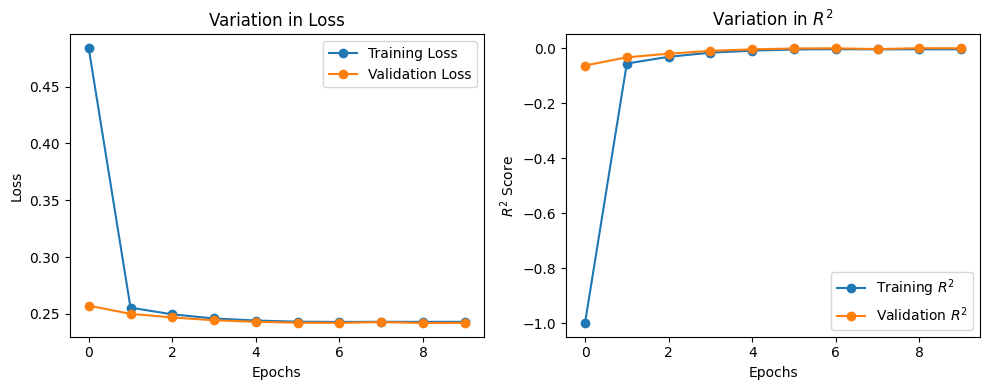

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Plotting training and validation losses with dots
ax[0].plot(range(len(train_losses)), train_losses, label='Training Loss', marker='o')
ax[0].plot(range(len(val_losses)), val_losses, label='Validation Loss', marker='o')
ax[0].set_title('Variation in Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Plotting training and validation R^2 scores with dots
ax[1].plot(range(len(train_r2_scores)), train_r2_scores, label='Training $R^2$', marker='o')
ax[1].plot(range(len(val_r2_scores)), val_r2_scores, label='Validation $R^2$', marker='o')
ax[1].set_title('Variation in $R^2$')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('$R^2$ Score')
ax[1].legend()

plt.tight_layout()
plt.show()

The End